# Spacecraft anomalies

Reference used to obtain the maximum and minimum of the solar cycles:

https://www.spaceweatherlive.com/en/solar-activity/solar-cycle/historical-solar-cycles


## Import libraries

In [199]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap

## Plots configuration

In [2]:
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['legend.loc'] = 'upper left'

## Import data

datasets-113110-269962-GoesAnomalyTrends.xls == GoesAnomalyTrends.xls

tdrs5j.xls only contains 5 records. It won't be taken into account.

anom5j.xls

- VER: Format version 
- EDATE: Date  that this  anomaly report was entered (CCYYMMDD) 
- BIRD: Spacecraft identification,  i.e GOES-2,  @AA0301, @AA0302.
               Alias spacecraft identifications should be 7 digits:
               1 = @,  Digit 2-3 = Contributors ID,
               4-5 = spacecraft family, 6-7 = sequence # within the family
- ADATE: Date of anomaly (CCYYMMDD Universal Time)
- STIMEU: Start time of anomaly, 9999 = no time (HHMM Universal Time)
- STIMEQ: Uncertainty in time (Minutes)
- DUR: Duration (Minutes)
- STIMEL: Time of anomaly (HHMM Local Time)
- ORBIT:  Orbit type
            G= geostationary
            P= polar circular
            E= elliptical
            I= GPS orbit
            S= SSO
            V= Venus orbit
            C= circular orbit
- NS: N= North, S= South for following latitude, blank => no Lat.
- LAT: Geographic latitude of sub-orbit point at anomaly start
- LATQ: Uncertainty in latitude (Degrees)
- EW: E= east, W= west for following longitude, blank => no Lon
- LON: Geographic longitude of sub-orbit point at anomaly start
- LONQ: Uncertainty in longitude (Degrees)
- ALT: Altitude (Kilometers)
- ATYPE: Anomaly type,  what was the anomalous behavior?
        The coded definitions will evolve as needed.
             PC   : Phantom Command - uncommanded status change.
             PF   : Part Failure.
             TE   : Telemetry Error.
             SE   : Soft Error, recoverable bit flip type error.
             HE   : Hard Error, permanent chip damage or Latch-Up.
             SS   : System Shutdown.
             ESDM : ElectroStatic Discharge Measured (SCATHA specific).
             ATT  : Attitude Control Problem.
             UNK  : Unknown.
- ADIAG: Anomaly diagnosis, what type of event caused the anomaly?
       The coded definitions will evolve as needed.
            ECEMP : Electron Caused ElectroMagnetic Pulse.
                    Internal, Deep dielectric charging
            ESD   : ElectroStatic Discharge.
                    Surface charging
            SEU   : Single Event Upset, Solar or Galactic Cosmic Rays.
            MCP   : Mission Control Problem, human induced or software
                    error.
            RFI   : Radio Frequency Interference.
            UNK   : Unknown diagnosis.
- ACOMMENT: Comment related to the anomaly
- SVE: Sun-Vehicle-Earth angle in degrees.
- SPIN: S = spin stabilized, A = 3-Axis stabilized

In [3]:
anom = pd.read_excel('data/anom5j.xls', parse_dates=['ADATE'])
anom.head()

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,VER,EDATE,BIRD,ADATE,STIMEU,STIMEQ,DUR,STIMEL,ORBIT,NS,...,LATQ,EW,LON,LONQ,ALT,ATYPE,ADIAG,ACOMMENT,SVE,SPIN
0,5.0,1994-01-19,AFSATCOM,1990-09-11,2000,NaN,0,1632.0,G,NaN,...,NaN,E,308,NaN,35784,UNK,UNK,SFC(129) Decoder problem.,0.0,NaN
1,5.0,1994-01-19,AFTAC/WE,1992-04-15,838,NaN,0,2138.0,G,NaN,...,NaN,E,195,NaN,35784,UNK,UNK,SFC(116) Temperature sensor failure. / AP=QUIE...,0.0,NaN
2,5.0,1994-01-19,AMPTE/CCE,1987-10-27,1408,NaN,0,120.0,E,N,...,NaN,E,168,NaN,54810,UNK,UNK,SFC(118) Power supply problem.,0.0,NaN
3,5.0,1986-12-11,@PN0101,1978-10-04,1915,0.0,0,1219.0,G,N,...,0.0,W,104,0.0,35784,PC,ESD,ENCODER 2 MODE SWITCH,0.0,NaN
4,5.0,1986-12-11,@PN0102,1974-06-15,338,0.0,0,2042.0,G,N,...,0.0,W,104,0.0,35784,PC,ESD,ENCODER 2 MODE SWITCH - SENSOR TO PAM,0.0,NaN


## Data cleaning

Check the type of all the variables:

In [4]:
anom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5033 entries, 0 to 5032
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   VER       5032 non-null   float64       
 1   EDATE     5033 non-null   datetime64[ns]
 2   BIRD      5033 non-null   object        
 3   ADATE     5033 non-null   datetime64[ns]
 4   STIMEU    5033 non-null   int64         
 5   STIMEQ    4150 non-null   float64       
 6   DUR       5033 non-null   int64         
 7   STIMEL    3508 non-null   float64       
 8   ORBIT     4577 non-null   object        
 9   NS        2999 non-null   object        
 10  LAT       5033 non-null   int64         
 11  LATQ      4150 non-null   float64       
 12  EW        3672 non-null   object        
 13  LON       5033 non-null   int64         
 14  LONQ      4150 non-null   float64       
 15  ALT       5033 non-null   int64         
 16  ATYPE     4984 non-null   object        
 17  ADIAG     4986

Check if there are null values and how many:

In [5]:
anom.isnull().sum()

VER            1
EDATE          0
BIRD           0
ADATE          0
STIMEU         0
STIMEQ       883
DUR            0
STIMEL      1525
ORBIT        456
NS          2034
LAT            0
LATQ         883
EW          1361
LON            0
LONQ         883
ALT            0
ATYPE         49
ADIAG         47
ACOMMENT    1393
SVE          354
SPIN        4717
dtype: int64

### Delete the columns not useful

The version, the date the anomaly was introduced and the angle between Sun-Vehicle-Earth won't be used.
The ACOMMENT column doesn't bring any new information.

In [6]:
anom.drop(columns=['VER', 'EDATE', 'SVE', 'ACOMMENT'], inplace=True)

The column SPIN doesn't bring any information. There is only one S/C in spin control mode.

In [7]:
anom[anom['SPIN']=='S']['BIRD'].unique()

array(['SCATHA'], dtype=object)

In [8]:
anom.drop(columns=['SPIN'], inplace=True)

### Null values for the ORBIT parameter

#### Check if for the same spacecraft the orbit values are not null

In some cases, for the same spacecraft ID (BIRD) the orbit is not always set

In [9]:
# Function to find the orbit if it has been defined for any of the entries for that S/C

def findorbit(x):
    result = anom[(anom['BIRD']==x.BIRD) & (~anom['ORBIT'].isnull())]
      
    if result.empty:
        pass
    else:
         return result['ORBIT'].iloc[0]

In [10]:
anom['ORBIT'] = anom.apply(findorbit, axis=1)

Check if there are still some spacecrafts without orbit identifier:

In [11]:
anom['BIRD'][anom['ORBIT'].isnull()].unique()

array(['APPLE', 'ARABSAT-1A', 'ARABSAT-1B', 'ATS-2', 'ATS-4', 'ATS-5',
       'BIG-BIRD', 'BS-2A', 'BS-2B', 'BS-3', 'COMSTAR-D3', 'COMSTAR-D4',
       'DSCS-3-02', 'DSCS-F11', 'DSCS-F13', 'DSCS-F14', 'ECS-1', 'ECS-2',
       'ECS-3', 'ERBS', 'FLTSA-F2', 'FLTSA-F3', 'FLTSA-F4', 'FLTSA-F5',
       'GALAXY-2', 'GEOS-1', 'GSTAR-1', 'GSTAR-2', 'IDSCS-2', 'IMEWS-1',
       'INSAT-1A', '@GG0K', '@GG0201', '@GG0301', '@GG0305', '@GG0308',
       '@GG0406', '@GG0509', '@GG0511', '@GG0512', '@GG0514', 'ISS-NASDA',
       'KH-11', 'KU2', 'LANDSAT', 'MARECS-B', 'MARECS-B2', 'MORELOS-T1',
       'MORELOS-T2', 'NAVSTAR', 'NOAA-08', 'OSCAR-10', 'OTS-1', 'OTS-2',
       'PALAPA-B1', 'PALAPA-B2', 'SATCOM-1', 'SATCOM-1R', 'SATCOM-2',
       'SATCOM-2R', 'SATCOM-3', 'SATCOM-3R', 'SATCOM-4', 'SBS-1', 'SBS-2',
       'SBS-3', 'SIRIO-2', 'SKYNET-1B', 'SKYNET-2A', 'SPACENET-1',
       'SPACENET-2', 'SPACENET-3', 'SPOT-1', 'SYNCOM-1', 'SYNCOM-IV2',
       'SYNCOM-IV3', 'SYNCOM-IV4', 'TDRS-2', 'TDRS-5', 'TDRS-

#### Manual input of the ORBIT parameter
Find in the internet the orbit of the spacecrafts with public name:

In [12]:
anom.loc[anom['BIRD'].str.contains('WESTAR') ,'ORBIT'] = 'G'
anom.loc[anom['BIRD'].str.contains('ARABSAT') ,'ORBIT'] = 'G'
anom.loc[anom['BIRD'].str.contains('ARABSAT') ,'ORBIT'] = 'G'
anom.loc[anom['BIRD'].str.contains('ATS-2') ,'ORBIT'] = 'E'
anom.loc[anom['BIRD'].str.contains('ATS-4') ,'ORBIT'] = 'E'
anom.loc[anom['BIRD'].str.contains('ATS-5') ,'ORBIT'] = 'G'
anom.loc[anom['BIRD'].str.contains('BS-') ,'ORBIT'] = 'G' #SBS and BS satellites
anom.loc[anom['BIRD'].str.contains('COMSTAR') ,'ORBIT'] = 'G'
anom.loc[anom['BIRD'].str.contains('DSCS-') ,'ORBIT'] = 'G'
anom.loc[anom['BIRD'].str.contains('ECS-') ,'ORBIT'] = 'G'
anom.loc[anom['BIRD'].str.contains('ERBS') ,'ORBIT'] = 'I' #non SSO with inclination 56.9° and h = 572-600km
anom.loc[anom['BIRD'].str.contains('GALAXY') ,'ORBIT'] = 'G'
anom.loc[anom['BIRD'].str.contains('GEOS') ,'ORBIT'] = 'G'
anom.loc[anom['BIRD'].str.contains('GSTAR') ,'ORBIT'] = 'G'
anom.loc[anom['BIRD'].str.contains('IMEWS') ,'ORBIT'] = 'G'
anom.loc[anom['BIRD'].str.contains('INSAT-1A') ,'ORBIT'] = 'G'
anom.loc[anom['BIRD'].str.contains('TIROS') ,'ORBIT'] = 'S'
anom.loc[anom['BIRD'].str.contains('TELECOM') ,'ORBIT'] = 'G'
anom.loc[anom['BIRD'].str.contains('SPACENET') ,'ORBIT'] = 'G'
anom.loc[anom['BIRD'].str.contains('SATCOM-') ,'ORBIT'] = 'G'
anom.loc[anom['BIRD'].str.contains('MORELOS-') ,'ORBIT'] = 'G'
anom.loc[anom['BIRD'].str.contains('SKYNET-') ,'ORBIT'] = 'G'
anom.loc[anom['BIRD'].str.contains('SYNCOM-') ,'ORBIT'] = 'G'
anom.loc[anom['BIRD'].str.contains('TDRS-') ,'ORBIT'] = 'G'
anom.loc[anom['BIRD'].str.contains('PALAPA-') ,'ORBIT'] = 'G'
anom.loc[anom['BIRD'].str.contains('OTS-') ,'ORBIT'] = 'G'
anom.loc[anom['BIRD'].str.contains('NAVSTAR') ,'ORBIT'] = 'I' # GPS S/C

### Create Year, Month, Day columns

In [13]:
anom['YEAR'] = anom['ADATE'].dt.year
anom['MONTH'] = anom['ADATE'].dt.month
anom['DAY'] = anom['ADATE'].dt.day

In [14]:
anom['YEAR'].unique()

array([1990, 1992, 1987, 1978, 1974, 1977, 1983, 1984, 1979, 1985, 1986,
       1988, 1989, 1982, 1994, 1981, 1967, 1968, 1969, 1980, 1991, 1973,
       1975, 1993, 1966, 1970, 1976, 1971, 1972, 1963])

### Check how many unique satellites there are

In [15]:
anom['BIRD'].nunique()

259

## Anomalies analysis

Add a - sign to the south latitudes and west longitudes so the locations can be used in the plots:

In [16]:
anom.loc[anom['NS']=='S', 'LAT'] = -anom['LAT']
anom.loc[anom['EW']=='W', 'LON'] = -anom['LON']

### Define a routine to draw the world map

This function will be used when creating world maps plots

In [17]:
from itertools import chain

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13), labels=[True,False])
    lons = m.drawmeridians(np.linspace(-180, 180, 13), labels=[0,0,0,1])

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

### Anomalies locations by orbit type

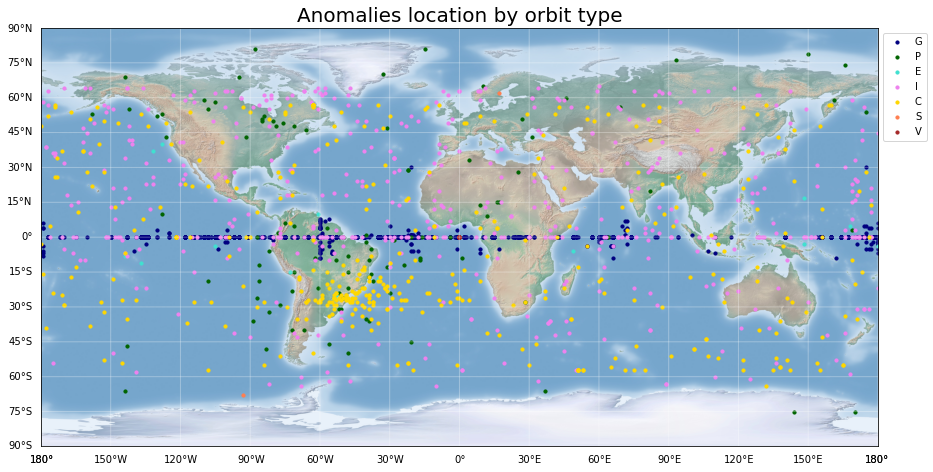

In [18]:
fig = plt.figure(figsize=(15, 10), edgecolor='w')

# Create the map
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180 )

# Plot coordinates
x, y = m(anom[anom['ORBIT']=='G'].LON, anom[anom['ORBIT']=='G'].LAT)
m.scatter(x, y, latlon=True, marker='o', color='navy', s=10, label='G')

x, y = m(anom[anom['ORBIT']=='P'].LON, anom[anom['ORBIT']=='P'].LAT)
m.scatter(x, y, latlon=True, marker='o', color='darkgreen', s=10, label='P')

x, y = m(anom[anom['ORBIT']=='E'].LON, anom[anom['ORBIT']=='E'].LAT)
m.scatter(x, y, latlon=True, marker='o', color='turquoise', s=10, label='E')

x, y = m(anom[anom['ORBIT']=='I'].LON, anom[anom['ORBIT']=='I'].LAT)
m.scatter(x, y, latlon=True, marker='o', color='violet', s=10, label='I')

x, y = m(anom[anom['ORBIT']=='C'].LON, anom[anom['ORBIT']=='C'].LAT)
m.scatter(x, y, latlon=True, marker='o', color='gold', s=10, label='C')

x, y = m(anom[anom['ORBIT']=='S'].LON, anom[anom['ORBIT']=='S'].LAT)
m.scatter(x, y, latlon=True, marker='o', color='coral', s=10, label='S')

x, y = m(anom[anom['ORBIT']=='V'].LON, anom[anom['ORBIT']=='V'].LAT)
m.scatter(x, y, latlon=True, marker='o', color='brown', s=10, label='V')

# Plot properties
plt.title('Anomalies location by orbit type')
plt.legend(bbox_to_anchor=(1.0,1.0))

draw_map(m)

We can observe that the spacecrafts with circular orbit have mainly anomalies in the South Atlantic Anomaly (SAA). This is expected.

### Anomalies locations by altitude

Using the type of orbit in the previous graph didn't bring in a lot of information. This is why, I am going to divide the orbits depending on their height into the following categories:

- LEO: h < 2000 km
- MEO: 2000 < h < 35000 km
- GEO: 35000 < h < 36000 km
- HEO: h > 36000 km

It can be seen in the distribution plot below that there are 3 main groups

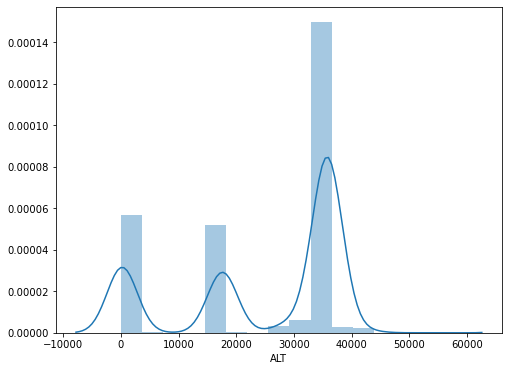

In [68]:
sns.distplot(anom['ALT'], bins=15)

#### Create a new column with the category corresponding depending on the altitude

In [19]:
anom['ALT_CAT'] = np.where(anom['ALT']<2000, 'LEO', 
                    np.where((anom['ALT']>2000) & (anom['ALT']<35000), 'MEO', 
                    np.where((anom['ALT']>35000) & (anom['ALT']<36000), 'GEO', 'HEO')))

This is how the distribution plot lookgs taking into account the 4 categories:

/Users/lola/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/lola/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


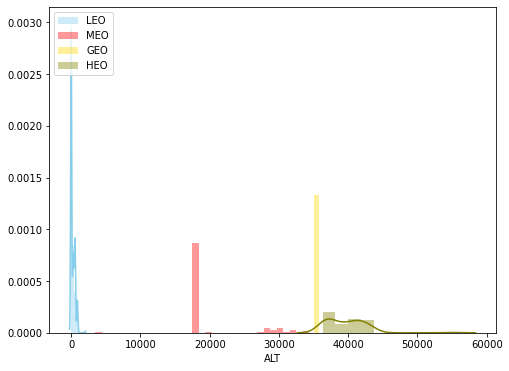

In [94]:
sns.distplot( anom[anom['ALT_CAT']=='LEO']['ALT'] , color="skyblue", label="LEO", bins=10)
sns.distplot( anom[anom['ALT_CAT']=='MEO']['ALT'] , color="red", label="MEO")
sns.distplot( anom[anom['ALT_CAT']=='GEO']['ALT'] , color="gold", label="GEO", bins=1)
sns.distplot( anom[anom['ALT_CAT']=='HEO']['ALT'] , color="olive", label="HEO")
plt.legend()

#### Plot the locations

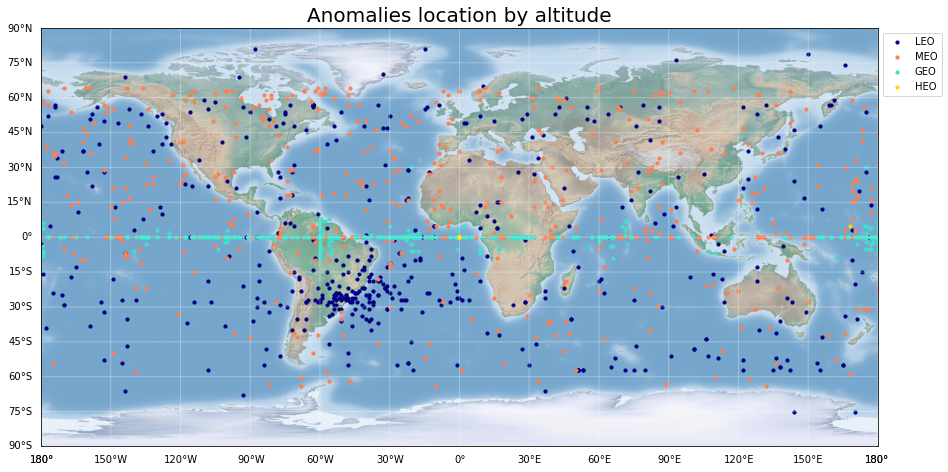

In [20]:
fig = plt.figure(figsize=(15, 10), edgecolor='w')

# Create the map
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180 )

# Plot coordinates
x, y = m(anom[anom['ALT_CAT']=='LEO'].LON, anom[anom['ALT_CAT']=='LEO'].LAT)
m.scatter(x, y, latlon=True, marker='o', color='navy', s=10, label='LEO')

x, y = m(anom[anom['ALT_CAT']=='MEO'].LON, anom[anom['ALT_CAT']=='MEO'].LAT)
m.scatter(x, y, latlon=True, marker='o', color='coral', s=10, label='MEO')

x, y = m(anom[anom['ALT_CAT']=='GEO'].LON, anom[anom['ALT_CAT']=='GEO'].LAT)
m.scatter(x, y, latlon=True, marker='o', color='turquoise', s=10, label='GEO')

x, y = m(anom[anom['ALT_CAT']=='HEO'].LON, anom[anom['ALT_CAT']=='HEO'].LAT)
m.scatter(x, y, latlon=True, marker='o', color='gold', s=10, label='HEO')

# Plot properties
plt.title('Anomalies location by altitude')
plt.legend(bbox_to_anchor=(1.0,1.0))

draw_map(m)

For LEO spacecrafts, most of the anomalies happens in the SAA.
For MEO, they seem to be randomly spread around.
And for GEO spacecrafts as their position is fixed, they happen in the same location always.

### Anomalies taking into account the position in inner Van Allen Belt 

As until now the analysis hasn't brought any conclusion, it might be better to analyze the anomalies depending if the spacecrafts are inside or outside the inner Van Allen Belt, which is at around 1000km.

#### Create a new category

The first thing is to create a new column where:
- 1 = inside the inner Van Allen Belt
- 0 = outside the inner Van Allen Belt

In [22]:
# 1: inside the inner Van Allen Belt
# 0: outside the inner Van Allen Belt
anom['VAN_ALLEN'] = np.where(anom['ALT']<1000, 1, 0)

#### Plot the locations of the anomalies depeding on the position respect to the Van Allen Belts

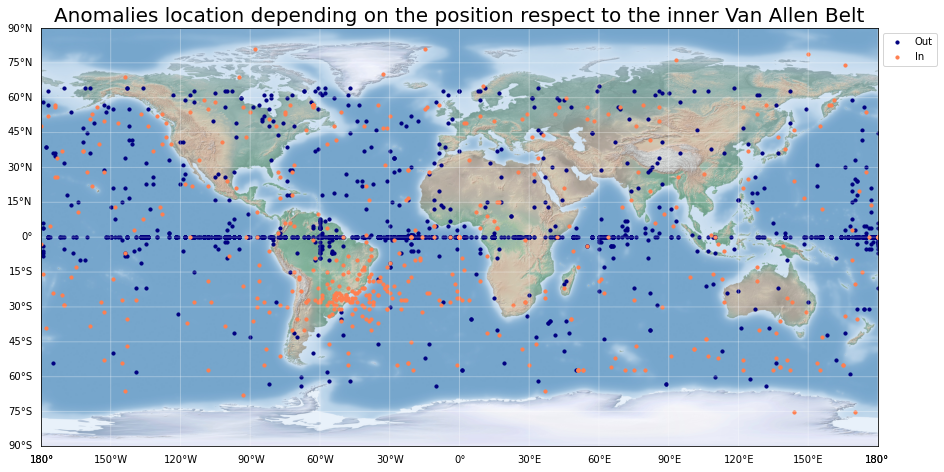

In [122]:
fig = plt.figure(figsize=(15, 10), edgecolor='w')

# Create the map
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180 )

# Plot coordinates
x, y = m(anom[anom['VAN_ALLEN']==0].LON, anom[anom['VAN_ALLEN']==0].LAT)
m.scatter(x, y, latlon=True, marker='o', color='navy', s=10, label='Out')

x, y = m(anom[anom['VAN_ALLEN']==1].LON, anom[anom['VAN_ALLEN']==1].LAT)
m.scatter(x, y, latlon=True, marker='o', color='coral', s=10, label='In')


# Plot properties
plt.title('Anomalies location depending on the position respect to the inner Van Allen Belt')
plt.legend(bbox_to_anchor=(1.0,1.0))

draw_map(m)

Here we can see than inside the inner Van Allen Belt, the anomalies are more likely to happen in the SAA

#### Confidence interval of the position for anomalies inside the inner Van Allen Belt 

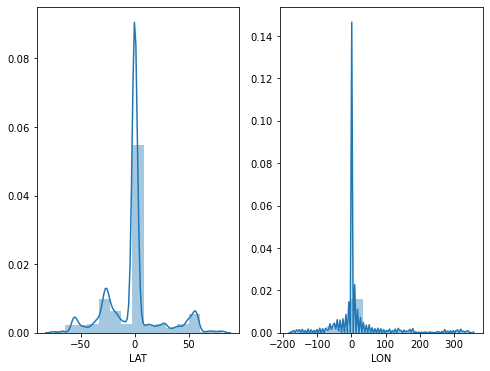

In [129]:
fig, ax = plt.subplots(1,2)

x = ['LAT', 'LON']

for i in range(2):
    plt.sca(ax[i])
    sns.distplot(anom[anom['VAN_ALLEN']==1][x[i]], bins=15)

The distribution of the longitud is normal. The ones for the latitude has 4 peaks, so it's not exactly normal distribution.

The confidence interval for the locations for the anomalies inside the innver Van Allen Belt is:

In [137]:
# function to calculate the confidence interval
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m-h, m+h

In [140]:
print('Confidence interval for the latitude (95%): ', 
      mean_confidence_interval(anom[anom['VAN_ALLEN']==1]['LAT'].values))

Confidence interval for the latitude (95%):  (-3.219715272024983, -0.2110539587442477)


In [141]:
print('Confidence interval for the longitude (95%): ', 
      mean_confidence_interval(anom[anom['VAN_ALLEN']==1]['LON'].values))

Confidence interval for the longitude (95%):  (7.79814338878556, 19.265318149675977)


#### Confidence interval of the position for anomalies outside the inner Van Allen Belt 

/Users/lola/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


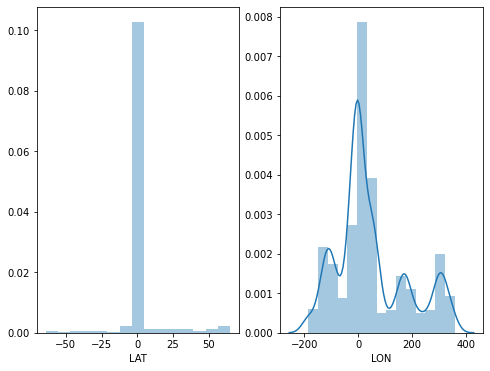

In [109]:
fig, ax = plt.subplots(1,2)

x = ['LAT', 'LON']

for i in range(2):
    plt.sca(ax[i])
    sns.distplot(anom[anom['VAN_ALLEN']==0][x[i]], bins=15)

For the longitude, it makes no sense to have an interval of confidence as the anomalies are distributed in all the values.
For the latitude, yes and it's confidence interval is the following:

In [142]:
print('Confidence interval for the latitude (95%): ', 
      mean_confidence_interval(anom[anom['VAN_ALLEN']==0]['LAT'].values))

Confidence interval for the latitude (95%):  (1.4202467070247957, 2.2236300773478566)


This was seen in the world map, as most os the anomalies outside the inner Van Allen Belt were around the equator (latitude=0°)

#### Propocinality test: more errors inside or outside the inner Van Allen Belt?

The hypothesis are:

- H0: the proportion of anomalies outside the inner Van Allen Belt is equal to 60%
- H1: the proportion of anomalies outside the inner Van Allen Belt is different to 60%

In [172]:
alpha = 0.05;

st, p = proportions_ztest(count=anom['VAN_ALLEN'].value_counts(), nobs=anom.shape[0], value=0.60)

print("Null hypothesis rejected") if p < alpha else print("Null hypothesis can't be rejected")

print('Statistic: ', st)
print('p-value: ', p)

Null hypothesis can't be rejected
Statistic:  -1.3316129042194866
p-value:  0.18298742234899423


At least 60% of the anomalies occur outside the inner Van Allen Belt.

It was calculated with 65% and the null hypothesis was rejected.

### Plot the location by anomaly type

Let's see if the anomaly types are more likely to happen in one location than other:

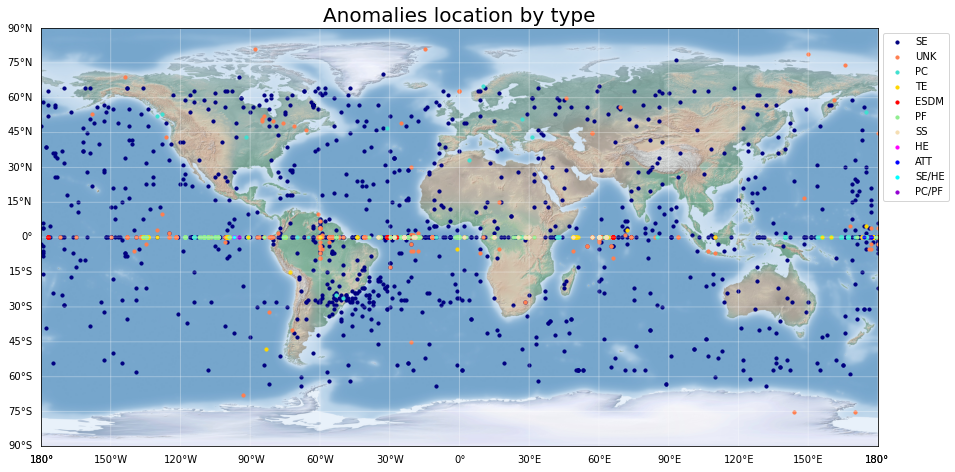

In [21]:
fig = plt.figure(figsize=(15, 10), edgecolor='w')

# Create the map
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180 )

# Plot coordinates
x, y = m(anom[anom['ATYPE']=='SE'].LON, anom[anom['ATYPE']=='SE'].LAT)
m.scatter(x, y, latlon=True, marker='o', color='navy', s=10, label='SE')

x, y = m(anom[anom['ATYPE']=='UNK'].LON, anom[anom['ATYPE']=='UNK'].LAT)
m.scatter(x, y, latlon=True, marker='o', color='coral', s=10, label='UNK')

x, y = m(anom[anom['ATYPE']=='PC'].LON, anom[anom['ATYPE']=='PC'].LAT)
m.scatter(x, y, latlon=True, marker='o', color='turquoise', s=10, label='PC')

x, y = m(anom[anom['ATYPE']=='TE'].LON, anom[anom['ATYPE']=='TE'].LAT)
m.scatter(x, y, latlon=True, marker='o', color='gold', s=10, label='TE')

x, y = m(anom[anom['ATYPE']=='ESDM'].LON, anom[anom['ATYPE']=='ESDM'].LAT)
m.scatter(x, y, latlon=True, marker='o', color='red', s=10, label='ESDM')

x, y = m(anom[anom['ATYPE']=='PF'].LON, anom[anom['ATYPE']=='PF'].LAT)
m.scatter(x, y, latlon=True, marker='o', color='lightgreen', s=10, label='PF')

x, y = m(anom[anom['ATYPE']=='SS'].LON, anom[anom['ATYPE']=='SS'].LAT)
m.scatter(x, y, latlon=True, marker='o', color='wheat', s=10, label='SS')

x, y = m(anom[anom['ATYPE']=='HE'].LON, anom[anom['ATYPE']=='HE'].LAT)
m.scatter(x, y, latlon=True, marker='o', color='fuchsia', s=10, label='HE')

x, y = m(anom[anom['ATYPE']=='ATT'].LON, anom[anom['ATYPE']=='ATT'].LAT)
m.scatter(x, y, latlon=True, marker='o', color='blue', s=10, label='ATT')

x, y = m(anom[anom['ATYPE']=='SE/HE'].LON, anom[anom['ATYPE']=='SE/HE'].LAT)
m.scatter(x, y, latlon=True, marker='o', color='aqua', s=10, label='SE/HE')

x, y = m(anom[anom['ATYPE']=='PC/PF'].LON, anom[anom['ATYPE']=='PC/PF'].LAT)
m.scatter(x, y, latlon=True, marker='o', color='darkviolet', s=10, label='PC/PF')

# Plot properties
plt.title('Anomalies location by type')
plt.legend(bbox_to_anchor=(1.0,1.0))

draw_map(m)

The anomaly SE happens all around the world and all the others are more likely to happen in the GEO spacecrafts. This will be better reflected later.

### What were the anomalous behaviours?

#### Category/count plots

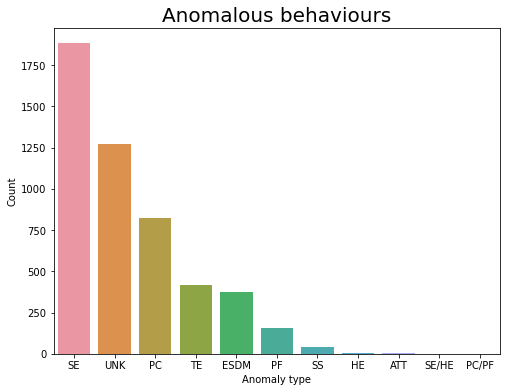

In [24]:
ax = sns.countplot(data=anom, x='ATYPE', order=anom['ATYPE'].value_counts().index)
ax.set(xlabel='Anomaly type', ylabel = 'Count', title='Anomalous behaviours');

Anomaly types by altitude category (LEO, MEO, GEO, HEO) with percentage of errors for each category:

- In HEO the most of the errors are ESDM
- In LEO the most common errors are SE and unknown
- In GEO the most common ones are PC, unknown, SE and TE
- In MEO the most of the errors are SE

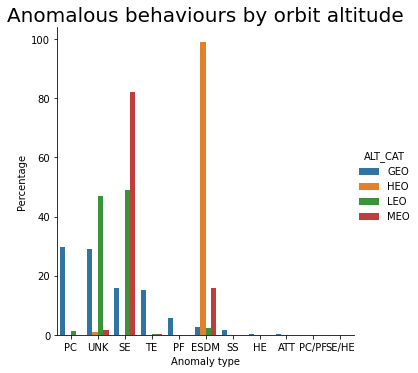

In [184]:
aux = anom.groupby('ALT_CAT')['ATYPE'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
ax = sns.catplot(data=aux, x='ATYPE', y='percent', hue='ALT_CAT', kind='bar')
ax.set(xlabel='Anomaly type', ylabel = 'Percentage', title='Anomalous behaviours by orbit altitude');

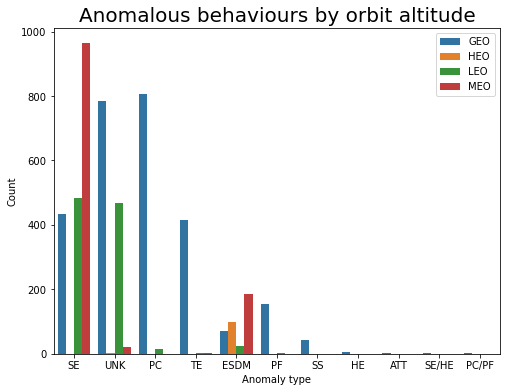

In [183]:
# Total number of errors in each category
ax = sns.countplot(data=anom, x='ATYPE', order=anom['ATYPE'].value_counts().index, hue='ALT_CAT')
ax.set(xlabel='Anomaly type', ylabel = 'Count', title='Anomalous behaviours by orbit altitude')
ax.legend(loc='upper right');

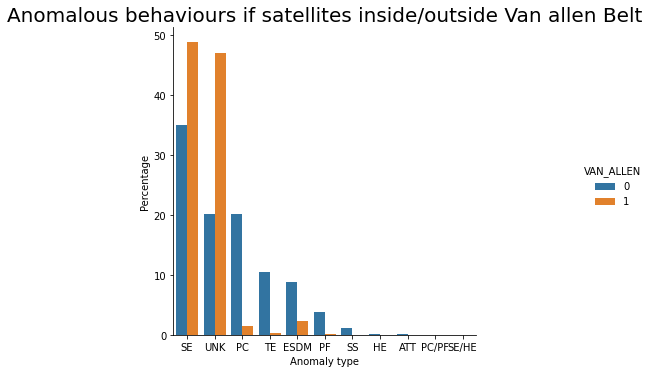

In [180]:
aux = anom.groupby('VAN_ALLEN')['ATYPE'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
ax = sns.catplot(data=aux, x='ATYPE', y='percent', hue='VAN_ALLEN', kind='bar')
ax.set(xlabel='Anomaly type', ylabel = 'Percentage', title='Anomalous behaviours if satellites inside/outside Van allen Belt');

The anomaly SE (Soft error) is more common inside the Van Allen Belt, then outside. Let's check how much often:

#### Proporcionality test for SE anomaly

The hypothesis are:
- H0: the proportion of SE anomalies outside the inner Van Allen Belt is equal to 50%
- H1: the proportion of SE anomalies outside the inner Van Allen Belt is different to 50%

In [198]:
alpha = 0.05;

st, p = proportions_ztest(count=anom[anom['ATYPE']=='SE']['VAN_ALLEN'].value_counts(), nobs=anom[anom['ATYPE']=='SE'].shape[0], value=0.50)

print("Null hypothesis rejected") if p < alpha else print("Null hypothesis can't be rejected")

print('Statistic: ', st)
print('p-value: ', p)

Null hypothesis can't be rejected
Statistic:  -0.8636458923059057
p-value:  0.38778244551286967


It can't be said that the SE are more common inside the Van Allen Belt than outside. Null hypothesis with value higher or lower than 50% is rejected.

### What type of event caused the anomalies?

In general, the diagnosis is the following:

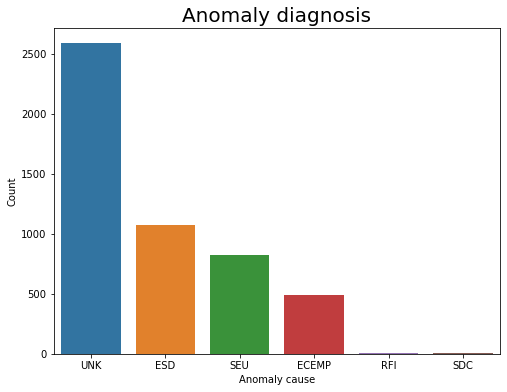

In [26]:
ax = sns.countplot(data=anom, x='ADIAG', order=anom['ADIAG'].value_counts().index)
ax.set(xlabel='Anomaly cause', ylabel = 'Count', title='Anomaly diagnosis');

Considering the percentage of each diagnosis by altitude category (LEO, MEO, GEO, HEO), the results are the following:

- In HEO the most common causes are ESD and ECEMP
- In LEO the most common causes are SEU and unknown
- In GEO the most common ones are unknown and ESD
- In MEO the most common cause is unknown

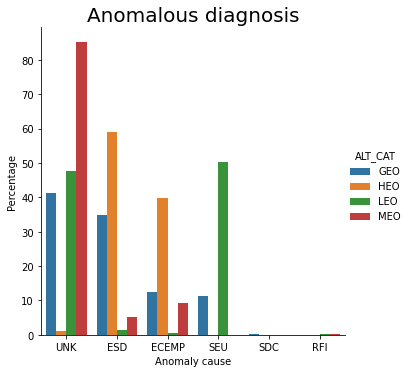

In [163]:
aux = anom.groupby('ALT_CAT')['ADIAG'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
ax = sns.catplot(data=aux, x='ADIAG', y='percent', hue='ALT_CAT', kind='bar')
ax.set(xlabel='Anomaly cause', ylabel = 'Percentage', title='Anomalous diagnosis');

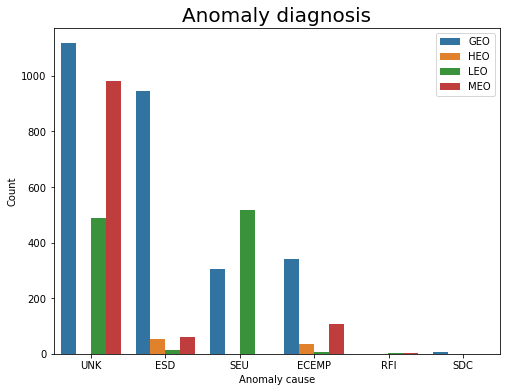

In [173]:
# Total number of causes in each category
ax = sns.countplot(data=anom, x='ADIAG', order=anom['ADIAG'].value_counts().index, hue='ALT_CAT')
ax.set(xlabel='Anomaly cause', ylabel = 'Count', title='Anomaly diagnosis')
ax.legend(loc='upper right');

### Correlation between anomaly type and cause

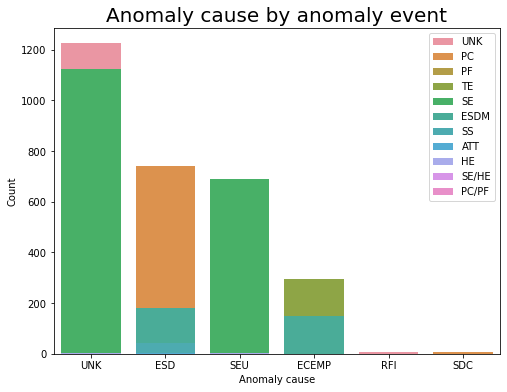

In [28]:
ax = sns.countplot(data=anom, x='ADIAG', hue='ATYPE', order=anom['ADIAG'].value_counts().index, dodge=False)
ax.set(xlabel='Anomaly cause', ylabel = 'Count', title='Anomaly cause by anomaly event');
plt.legend(loc='upper right');

### Distribution of anomalies per year by altitude

In the following plots, the distribution of anomalies by year are shown.

The yellow lines are the years of maximum solar cycle and the orange lines are the years of minimum solar cycle

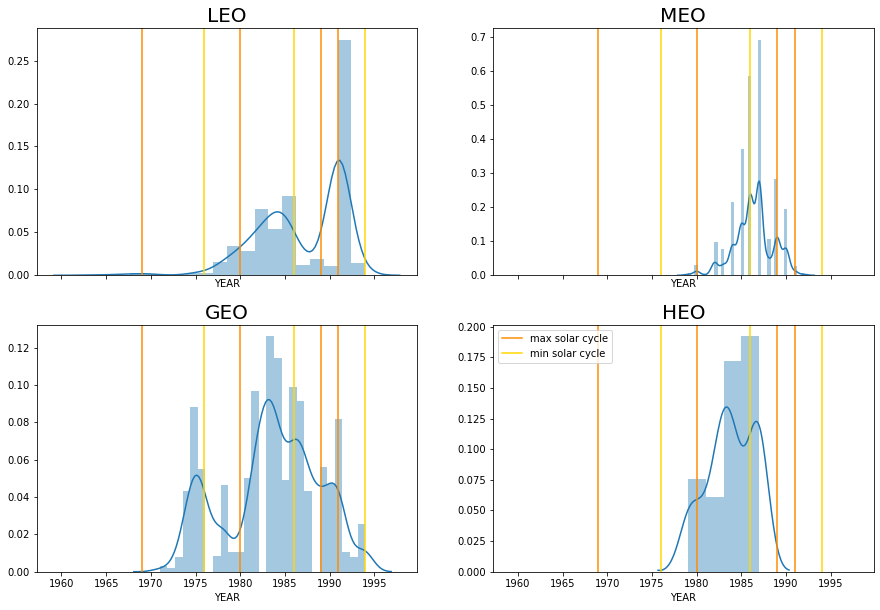

In [174]:
ALT_CAT = ['LEO', 'MEO', 'GEO', 'HEO']

# Create 4 subplots
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(15,10), sharex=True)

sns.distplot(anom[anom['ALT_CAT']==ALT_CAT[0]].YEAR, ax=ax[0,0])
sns.distplot(anom[anom['ALT_CAT']==ALT_CAT[1]].YEAR, ax=ax[0,1])
sns.distplot(anom[anom['ALT_CAT']==ALT_CAT[2]].YEAR, ax=ax[1,0])
sns.distplot(anom[anom['ALT_CAT']==ALT_CAT[3]].YEAR, ax=ax[1,1])

# Set titles
ax[0,0].set_title(ALT_CAT[0])
ax[0,1].set_title(ALT_CAT[1])
ax[1,0].set_title(ALT_CAT[2])
ax[1,1].set_title(ALT_CAT[3]);

for i in range(2):
    for j in range(2):
        ax[i,j].axvline(1969, 0, 1, color='darkorange', label='max solar cycle')
        ax[i,j].axvline(1980, 0, 1, color='darkorange')
        ax[i,j].axvline(1989, 0, 1, color='darkorange')
        ax[i,j].axvline(1991, 0, 1, color='darkorange')
        ax[i,j].axvline(1976, 0, 1, color='gold', label='min solar cycle')
        ax[i,j].axvline(1986, 0, 1, color='gold')
        ax[i,j].axvline(1994, 0, 1, color='gold')
plt.legend();

No conclusions from these plots, so let's try to see the same but considering the anomalies inside and outside the inner Van Allen Belt:

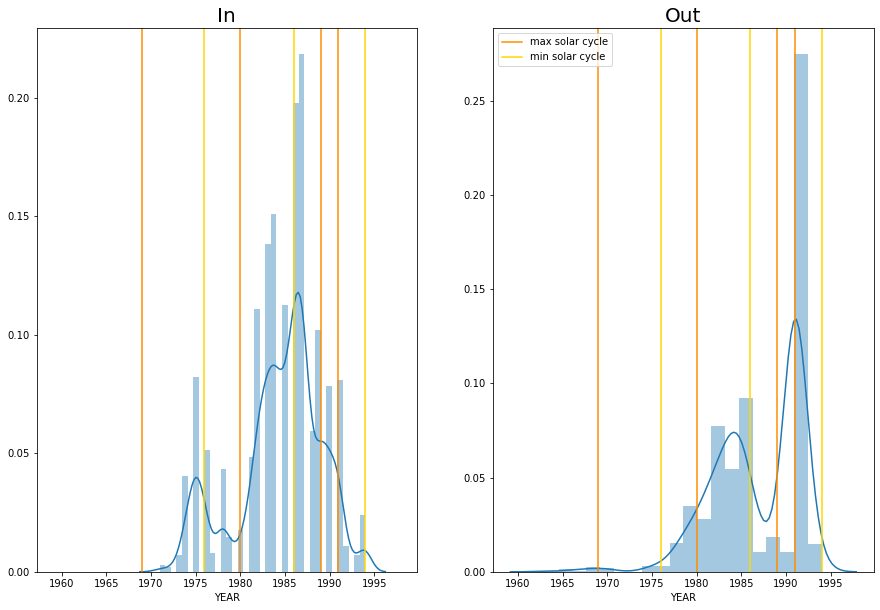

In [175]:
ALT_CAT = ['LEO', 'MEO', 'GEO', 'HEO']

# Create 4 subplots
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,10), sharex=True)

sns.distplot(anom[anom['VAN_ALLEN']==0].YEAR, ax=ax[0])
sns.distplot(anom[anom['VAN_ALLEN']==1].YEAR, ax=ax[1])

# Set titles
ax[0].set_title('In')
ax[1].set_title('Out');

for i in range(2):
    ax[i].axvline(1969, 0, 1, color='darkorange', label='max solar cycle')
    ax[i].axvline(1980, 0, 1, color='darkorange')
    ax[i].axvline(1989, 0, 1, color='darkorange')
    ax[i].axvline(1991, 0, 1, color='darkorange')
    ax[i].axvline(1976, 0, 1, color='gold', label='min solar cycle')
    ax[i].axvline(1986, 0, 1, color='gold')
    ax[i].axvline(1994, 0, 1, color='gold')
plt.legend();

It can be seen that inside the inner Van Allen Belt, the maximum occurs during the minimum solar cycle and outside, during the maximum.
This makes sense as during the maximum of the solar cycle the altitude of the inner Van Allen Belt increases, so it protects better all the satellites at low orbits. And during the minimum of the solar cycle, its altitude decreases, so there are more anomalies happening at low orbits.

### ANOVA test altitude/anomaly type

ANOVA helps to determine if the differences are statistically significant.
The variables chosen are:

- Categorical variable = anomaly type
- Numeric variable = altitude

In [203]:
anova_df_free = anom[['ALT', 'ATYPE']]

# Create ANOVA table
anova = ols("anom.ALT ~ C(anom['ATYPE'])", data=anom).fit()

print(anova.summary())

# We also check the mean and standard deviation for the groups
mean = anova_df_free.groupby("ATYPE").mean()
sd = anova_df_free.groupby("ATYPE").std()
print("\n Mean:",mean)
print("\n Standard deviation:",sd)

                            OLS Regression Results                            
Dep. Variable:               anom.ALT   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     199.6
Date:                Sun, 11 Oct 2020   Prob (F-statistic):               0.00
Time:                        22:29:32   Log-Likelihood:                -53896.
No. Observations:                4984   AIC:                         1.078e+05
Df Residuals:                    4973   BIC:                         1.079e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

p-value is smaller than 0.05, so the null hypothesis is rejected, which means that the anomaly type is not independent from the height of the orbit

### Pair plot to see if there is any correlation visible between the variables

In [178]:
anom_filtered = anom[['DUR', 'ORBIT', 'LAT', 'LON', 'ALT', 'ATYPE', 'YEAR', 'ALT_CAT', 'VAN_ALLEN']]

/Users/lola/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/lola/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/lola/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/lola/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/lola/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/lola/opt/anaconda3/lib/pytho

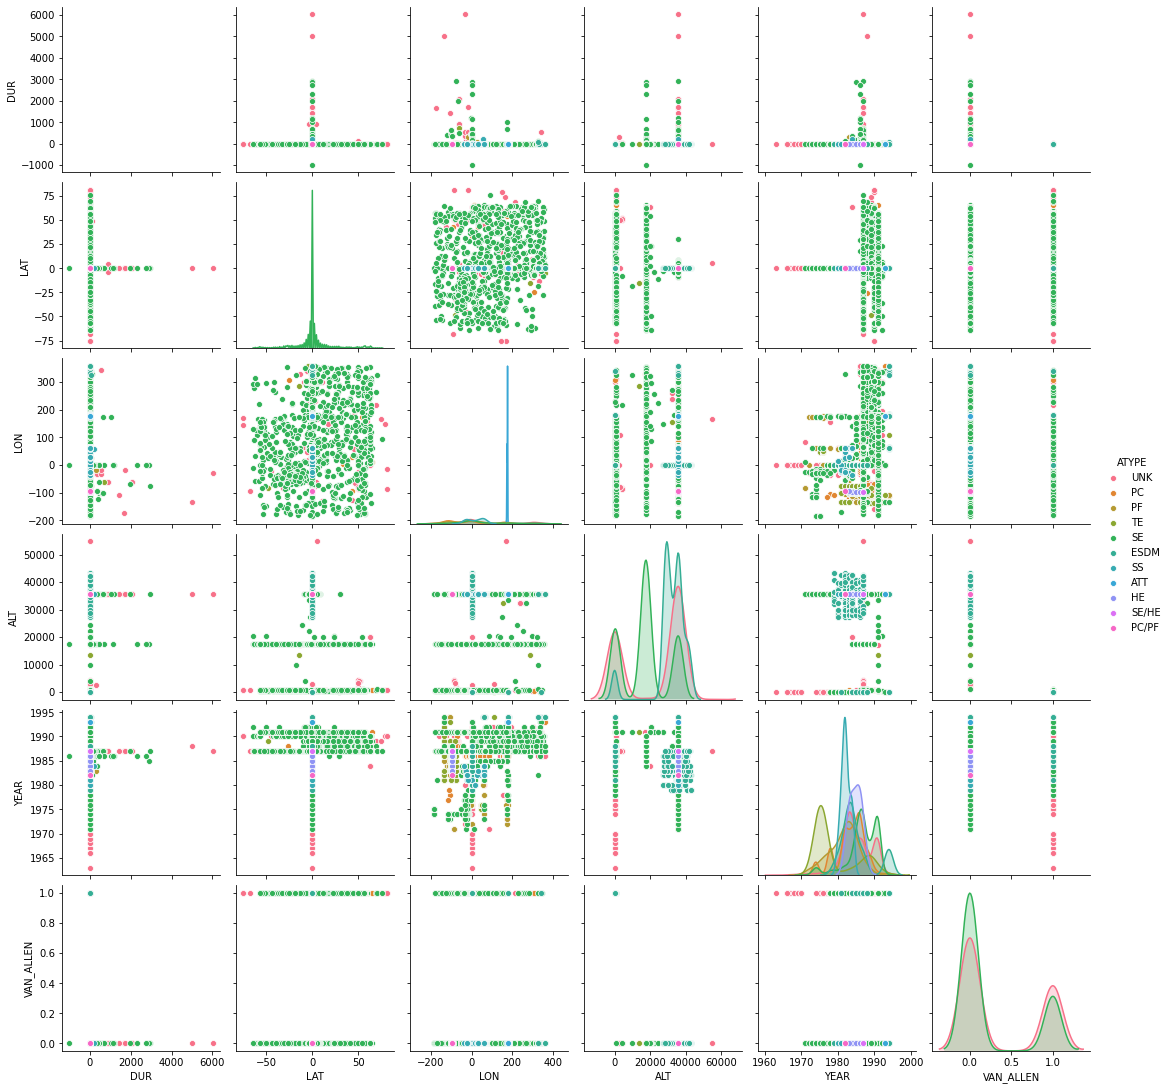

In [177]:
sns.pairplot(anom_filtered, hue='ATYPE')

Nothing from these plots. No clear information

### Anomalies count by month and year

In [33]:
df = anom.groupby(['YEAR', 'MONTH']).agg({'MONTH':sum})

In [34]:
df['COUNT'] = df['MONTH']

In [35]:
df.drop(columns='MONTH', inplace=True)

In [36]:
df.reset_index(inplace=True)

In [37]:
df

,YEAR,MONTH,COUNT
0,1963,2,2
1,1966,8,8
2,1966,10,10
3,1967,4,4
4,1968,8,8
...,...,...,...
258,1994,1,7
259,1994,2,24
260,1994,3,75
261,1994,4,88


In [38]:
df = df.pivot(index='MONTH', columns='YEAR', values='COUNT')

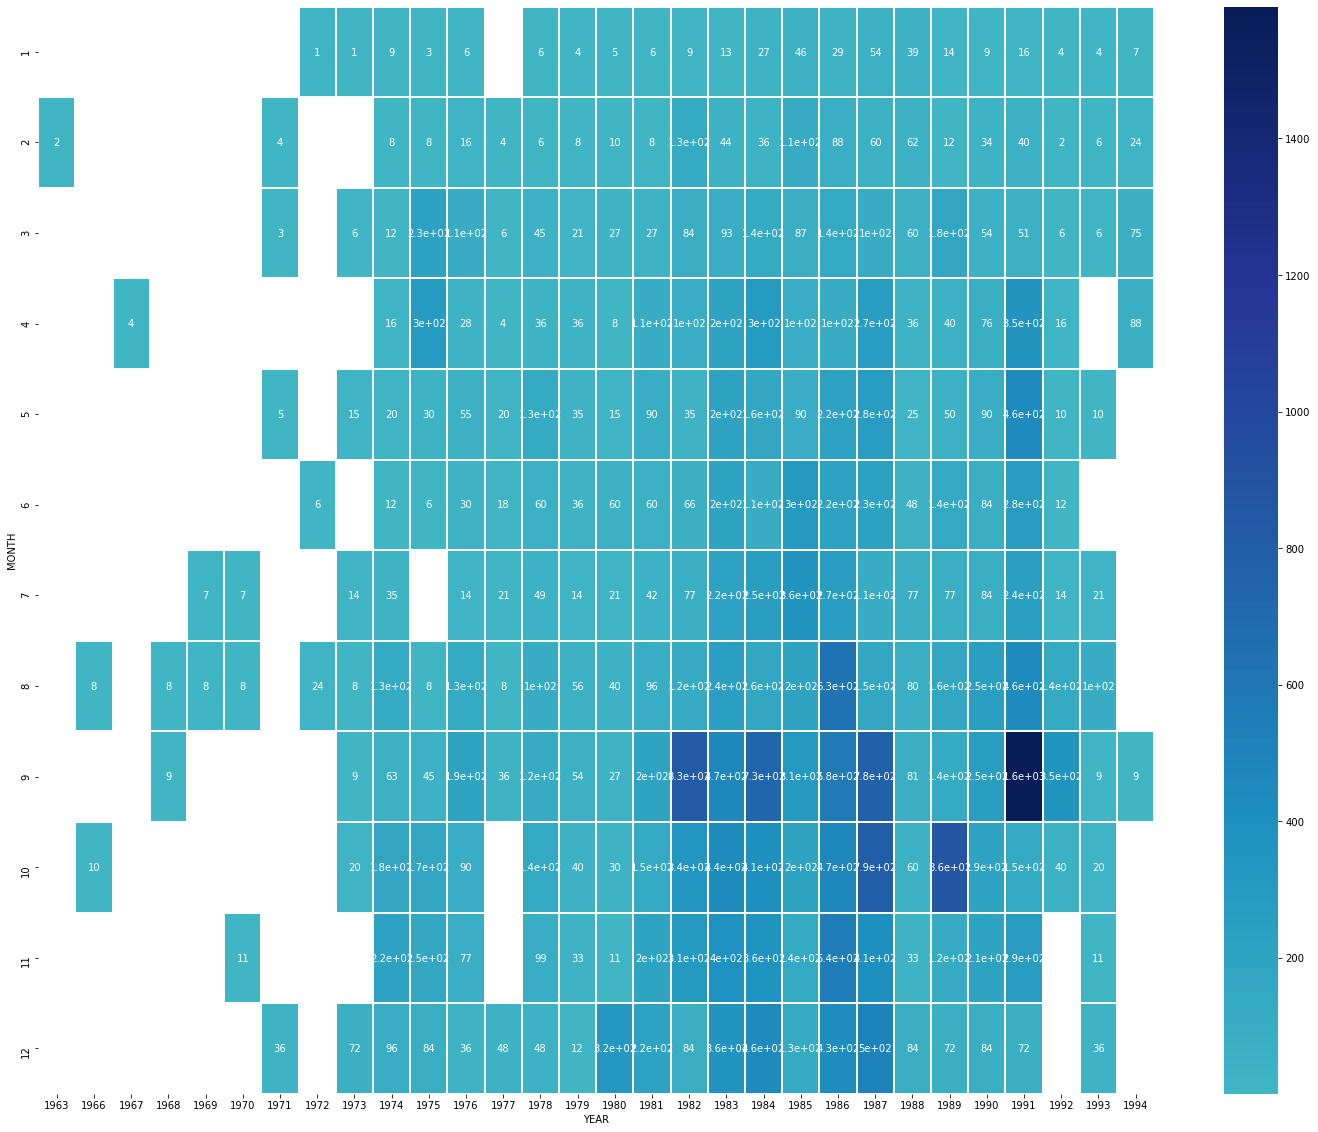

In [39]:
plt.figure(figsize=(25,20))
ax = sns.heatmap(df, cmap = 'YlGnBu', annot=True, linecolor = 'white',linewidths = 1, center=0)


### Number of unique spacecrafts per year and altitude

In [40]:
df = anom.groupby(['YEAR', 'ALT_CAT'])['BIRD'].nunique().reset_index()

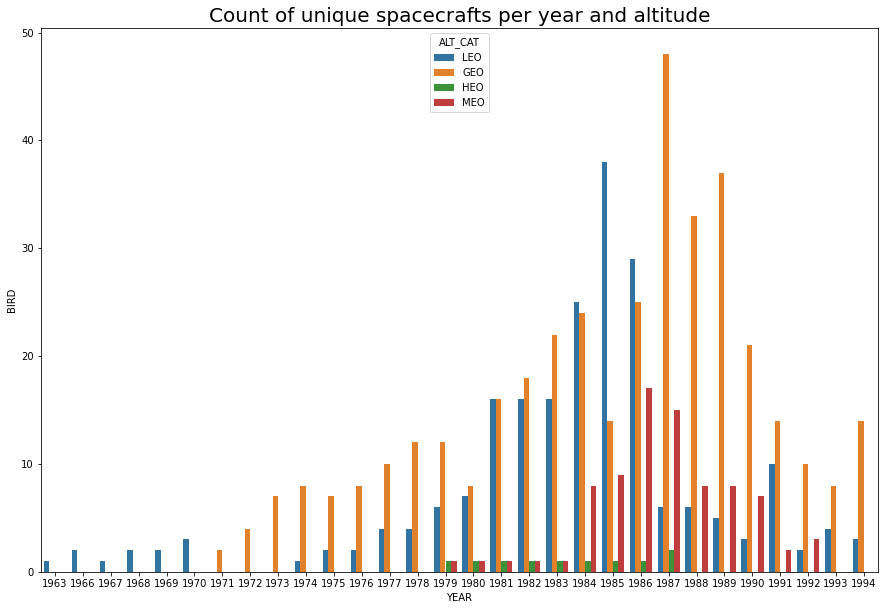

In [41]:
plt.figure(figsize=(15,10))
sns.barplot(x='YEAR', data=df, y='BIRD', hue='ALT_CAT')
plt.title('Count of unique spacecrafts per year and altitude');

In [42]:
anom

,BIRD,ADATE,STIMEU,STIMEQ,DUR,STIMEL,ORBIT,NS,LAT,LATQ,...,LON,LONQ,ALT,ATYPE,ADIAG,YEAR,MONTH,DAY,ALT_CAT,VAN_ALLEN
0,AFSATCOM,1990-09-11,2000,NaN,0,1632.0,G,NaN,0,NaN,...,308,NaN,35784,UNK,UNK,1990,9,11,GEO,0
1,AFTAC/WE,1992-04-15,838,NaN,0,2138.0,G,NaN,0,NaN,...,195,NaN,35784,UNK,UNK,1992,4,15,GEO,0
2,AMPTE/CCE,1987-10-27,1408,NaN,0,120.0,E,N,5,NaN,...,168,NaN,54810,UNK,UNK,1987,10,27,HEO,0
3,@PN0101,1978-10-04,1915,0.0,0,1219.0,G,N,0,0.0,...,-104,0.0,35784,PC,ESD,1978,10,4,GEO,0
4,@PN0102,1974-06-15,338,0.0,0,2042.0,G,N,0,0.0,...,-104,0.0,35784,PC,ESD,1974,6,15,GEO,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5028,WESTAR-4,1982-02-25,9999,0.0,0,NaN,G,NaN,0,0.0,...,0,0.0,0,UNK,UNK,1982,2,25,LEO,1
5029,WESTAR-4,1982-02-25,9999,0.0,0,NaN,G,NaN,0,0.0,...,0,0.0,0,UNK,UNK,1982,2,25,LEO,1
5030,WESTAR-5,1982-06-09,9999,0.0,0,NaN,G,NaN,0,0.0,...,0,0.0,0,UNK,UNK,1982,6,9,LEO,1
5031,WESTAR-5,1987-10-14,1750,NaN,0,NaN,G,NaN,0,NaN,...,238,NaN,35784,UNK,UNK,1987,10,14,GEO,0
